# FLOYao.jl

A backend to efficiently simulate fermionic linear optics (FLO) circuits in [Yao.jl](https://github.com/QuantumBFS/Yao.jlhttps://github.com/QuantumBFS/Yao.jl) based on [Classical simulation of noninteracting-fermion quantum circuits](https://arxiv.org/abs/quant-ph/0108010).

**Note**    
The markdown version of this README is automatically generated from `README.ipynb` and some 
of the hpyerlinks and math doesn't seem to play that well with githubs markdown parser. So you might want to have a look at the `README.ipynb` with jupyter instead for a better reading experience.

## Contents
 - [Installation](#Installation)
 - [Basic usage](#Basic-usage)
 - [List of supported gates](#List-of-supported-gates)
 - [Example: Transverse field Ising model](#Example:-Transverse-Field-Ising-model)
 - [Adding support for your own gates](#Adding-support-for-your-own-gates)
 - [Background: Fermionic linear optics circuits](#Background:-Fermionic-linear-optics-circuits)
 - [Known restrictions](#Known-restrictions)

## Installation

 > By the time this will be in the julia general registry, it should be as easy as opening
 > a julia REPL and typing
 >  ```julia
 >   pkg> add FLOYao
 >  ```

But for now I suggest the following way: First open a standard terminal and type 
```bash
cd your_favorite_folder_for_code
git clone git@github.com:PhaseCraft/FLOYao.jl
```
and then open a julia REPL and type
```
pkg> dev your_favorite_folder_for_code/FLOYao.jl
```
which should make `FLOYao.jl` discoverable for your standard julia installation. 
Under linux the standard folder for julia packages under development is `/home/username/.julia/dev`

## Basic usage
The heart of `FLOYao` is the `MajoranaReg` register type, which efficiently represents a state that is a [FLO unitary](#Background:-Fermionic-linear-optics-circuits) applied to the vacuum state $|0⋯0⟩$

First import `Yao` and `FLOYao`:

In [1]:
using Revise

In [12]:
using Yao, FLOYao

┌ Info: Precompiling FLOYao [6d9310a3-f1d0-41b7-8edb-11c1cf57cd2d]
└ @ Base loading.jl:1423


then build a (here somewhat arbitrary) circuit consisting only of [FLO gates](#Background:-Fermionic-linear-optics-circuits)

In [13]:
nq = 4
θ = π/8
circuit = chain(nq)

push!(circuit, put(nq, 3=>Rz(0.5)))

xxg1 = kron(nq, 1 => X, 2 => X)
rg = rot(xxg1, θ)
push!(circuit, rg)  

xxg2 = kron(nq, 2 => X, 3 => Z, 4 => X)
rg = rot(xxg2, θ)
push!(circuit, rg)  
push!(circuit, put(nq, 3=>Rz(0.5)))
push!(circuit, put(nq, 1=>Z))

xxg3 = kron(nq, 2 => X, 3 => X)
rg = rot(xxg3, θ)

circuit

nqubits: 4
chain
├─ put on (3)
│  └─ rot(Z, 0.5)
├─ rot(nqubits: 4
kron
├─ 1=>X
└─ 2=>X, 0.39269908169872414)
├─ rot(nqubits: 4
kron
├─ 2=>X
├─ 3=>Z
└─ 4=>X, 0.39269908169872414)
├─ put on (3)
│  └─ rot(Z, 0.5)
└─ put on (1)
   └─ Z


and define an observable that is a sum of squares of Majorana operators

In [14]:
hamiltonian = xxg1 + xxg2 + xxg3 + kron(nq, 2=>Z) + kron(nq, 3=>Z)

nqubits: 4
+
├─ kron
│  ├─ 1=>X
│  └─ 2=>X
├─ kron
│  ├─ 2=>X
│  ├─ 3=>Z
│  └─ 4=>X
├─ kron
│  ├─ 2=>X
│  └─ 3=>X
├─ kron
│  └─ 2=>Z
└─ kron
   └─ 3=>Z


and finally create a register in the computational zero state via

In [18]:
mreg = FLOYao.zero_state(nq)

MajoranaReg{Float64} with 4 qubits:
8×8 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

Other options to create registers are `FLOYao.product_state` and `FLOYao.zero_state_like`. `FLOYao.rand_state` is not implemented so far, because to do so I would need to rely on yet another dependency to create random orthogonal matrices.

Applying the circuit to the register works then exactly the same way as for a normal `ArrayReg` register:

In [44]:
apply(mreg, circuit)

MajoranaReg{Float64} with 4 qubits:
8×8 Matrix{Float64}:
 -1.0  -0.0       -0.0       -0.0       -0.0       -0.0       -0.0       -0.0
 -0.0  -0.92388    0.382683  -0.0       -0.0       -0.0       -0.0       -0.0
  0.0   0.382683   0.92388    0.0        0.0        0.0        0.0        0.0
  0.0   0.0        0.0        0.92388    0.0        0.0        0.382683   0.0
  0.0   0.0        0.0        0.0        0.540302   0.841471   0.0        0.0
  0.0   0.0        0.0        0.0       -0.841471   0.540302   0.0        0.0
  0.0   0.0        0.0       -0.382683   0.0        0.0        0.92388    0.0
  0.0   0.0        0.0        0.0        0.0        0.0        0.0        1.0

and the same goes for expectation values of observables

In [45]:
expval = expect(hamiltonian, mreg => circuit)

1.8535533905932737

or even gradients of these expectation values with respect to the circuit parameters

In [46]:
inδ, paramsδ = expect'(hamiltonian, mreg => circuit)

MajoranaReg{Float64}(4) => [0.0, -0.3535533905932738, -0.3535533905932738, 0.0]

Just to check that this is all consistent with running a full wavefunction simulation, we can apply the same circuit on an `ArrayReg` and compare the expectation values and gradients

In [47]:
areg = zero_state(nq)
expval_full = expect(hamiltonian, areg => circuit)
expval_full ≈ expval

true

In [48]:
inδ_full, paramsδ_full = expect'(hamiltonian, areg => circuit)
paramsδ ≈ paramsδ_full

true

## List of supported gates

The following gates are FLO gates and supported by `FLOYao.jl`:

|  Gate | Comment |
|-------|---------|
|  `XGate`   | Together with `Y` the only gate that does not preserve fermionic parity |
|  `YGate`   |   See above  |
|  `ZGate`   |         |
|  `RotationGate{⋯,⋯,YGate}`  | The only single qubit rotation gate since $R_x(θ)γ_i R_x(-θ)$ is not a linear combination of Majorana operators for all Majorana operators. Similar for $R_y$ |
| `PauliKronBlock` | A kronecker product of Pauli operators s.t. that first and last operator are either $X$ or $Y$ and all operators in between are $Z$.  |
| `RotationGate{⋯,⋯,PauliKronBlock}` | A rotation gate with generator as in the last line. |
| `AbstractMatrix` | Unless the gate type is already explicitely implemented or know to not be a FLO gate, `FLOYao` will try to automatically convert the gate matrix in the qubit basis to a matrix in the Majorana basis. But note that this is fairly slow (although still poly-time instead of exp-time) |


If you want to add support to your own gates, read [this section](#Adding-support-for-your-own-gates) to learn how to do that.

## Example: VQE for the Transverse Field Ising model

For a more realistic use case, we have a look at VQE for the Transverse Field Ising model on a line whose Hamiltonian is given as 
$$
    H = J ∑_i^{L-1} X_i X_{i+1} + h ∑_i^L Z_i = U + T.
$$
As Ansatz circuits we use the Hamiltonian Variational Ansatz
$$
    U(\vec θ) = ∏_i^p e^{-iθ_{i,U} U} e^{-iθ_{i,T} T} 
$$
with the initial state being the groundstate of the TFIM at $J = 0$, so $|ψ_i⟩ = |0⋯0⟩$

In [50]:
L = 100 # this is far beyond what is possible with a full wavefunction simulation
J = 0.5
h = -1.
p = 10

U = map(1:L-1) do i
    J * kron(L, i => X, i+1 => X)
end |> sum

T = map(1:L) do i
    h * kron(L, i => Z)
end |> sum

hamiltonian = T + U

circuit = chain(L)
for _ in 1:p
    for i in 1:L-1
        push!(circuit, rot(kron(L, i => X, i+1 => X), 0.))
    end
    for i in 1:L
        push!(circuit, put(L, i => Rz(0.)))
    end
end
nparams = nparameters(circuit)
dispatch!(circuit, rand(nparams) ./ 100)

ψ_i = FLOYao.zero_state(L);

now that we defined the hamiltonian, the ansatz circuit and the initial state we can perform
simple gradient descent on the energy expectation value to find an approximation to the
groundstate of $H$:

In [51]:
iterations = 100
γ = 2e-2

for i in 1:iterations
    _, grad = expect'(hamiltonian, ψ_i => circuit)
    dispatch!(-, circuit, γ * grad)
    println("Iteration $i, energy = $(expect(hamiltonian, ψ_i => circuit))")
end

Iteration 1, energy = -99.89035562669795
Iteration 2, energy = -99.97636758476067
Iteration 3, energy = -100.00651404796758
Iteration 4, energy = -100.01907827842881
Iteration 5, energy = -100.02637787253676
Iteration 6, energy = -100.03241229504256
Iteration 7, energy = -100.03853006516084
Iteration 8, energy = -100.04524251891571
Iteration 9, energy = -100.05280464985711
Iteration 10, energy = -100.06140219187822
Iteration 11, energy = -100.07121310894155
Iteration 12, energy = -100.0824291396618
Iteration 13, energy = -100.09526474609267
Iteration 14, energy = -100.10996219044529
Iteration 15, energy = -100.12679550292142
Iteration 16, energy = -100.14607418342875
Iteration 17, energy = -100.16814684459939
Iteration 18, energy = -100.1934047724129
Iteration 19, energy = -100.22228527149565
Iteration 20, energy = -100.2552745838931
Iteration 21, energy = -100.29291009346443
Iteration 22, energy = -100.33578144425157
Iteration 23, energy = -100.38453010936321
Iteration 24, energy = -1

## Adding support for your own gates

Natively, the only FLO gates that come already shipped with `Yao.jl` are the gates listed [here](#List-of-supported-gates). But there are many more FLO gates, one being for example the `FSWAP` gate which swaps to qubits while making sure to preserve the fermionic commutation relations

In [52]:
@const_gate FSWAP::ComplexF64 = [1 0 0 0; 0 0 1 0; 0 1 0 0; 0 0 0 -1]

If a gate defines a matrix representation, as we just did for the `FSWAP`gate, `FLOYao` supports them out of the box by manually checking if they are a FLO gate and then computing its matrix representation in the Majorana basis. But this method is fairly slow–though still poly-time and memory–compared to directly implementing `unsafe_apply!(::MajoranaReg, ::YourBlock)` and  `instruct!(::MajoranaReg, ::YourBlock)` and will warn you accordingly

In [54]:
nq = 4
fswap = put(nq, (1, 2) => FSWAP)
mreg = FLOYao.zero_state(nq)
mreg |> put(nq, 2 => X)
mreg |> fswap

┌ Warning: Calling manual instruct!(MajoranaReg{Float64}(4), ComplexF64[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im -1.0 + 0.0im], (1, 2)).
│ You can greatly speed up your FLO gates by exactly implementing unsafe_apply!()
│ and instruct!() for them. See FLOYao/src/instruct.jl for how to do that.
└ @ FLOYao /home/yc20910/PhD/Work/code/FLOYao/src/instruct.jl:56


MajoranaReg{Float64} with 4 qubits:
8×8 Matrix{Float64}:
 -2.40901e-16  -2.94663e-16  -1.0          …   0.0   0.0   0.0   0.0
  3.57633e-16  -4.32975e-16  -1.0529e-16       0.0   0.0   0.0   0.0
 -1.0           1.20422e-17   2.61492e-16      0.0   0.0   0.0   0.0
 -7.05281e-17  -1.0           2.65282e-16      0.0   0.0   0.0   0.0
 -0.0          -0.0          -0.0             -1.0  -0.0  -0.0  -0.0
 -0.0          -0.0          -0.0          …  -0.0  -1.0  -0.0  -0.0
 -0.0          -0.0          -0.0             -0.0  -0.0  -1.0  -0.0
 -0.0          -0.0          -0.0             -0.0  -0.0  -0.0  -1.0

Now, before we fix these warnings, let's see how long the current implementation takes:

In [55]:
using BenchmarkTools
using Suppressor # we don't want to get all the warnings when benchmarking
@benchmark @suppress apply!($mreg, $fswap)

BenchmarkTools.Trial: 7275 samples with 1 evaluation.
 Range (min … max):  637.276 μs …   4.133 ms  ┊ GC (min … max): 0.00% … 79.28%
 Time  (median):     648.753 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   682.332 μs ± 256.195 μs  ┊ GC (mean ± σ):  3.03% ±  6.71%

  ▇█▆▄▄▃▂▁ ▁                                                    ▁
  ██████████▇█▇▆▅▇▇▆▅▅▅▅▃▃▄▁▁▃▃▃▄▄▃▁▄▄▄▅▃▄▄▅▁▅▁▃▃▄▃▁▃▁▁▁▁▁▅▆▆▆▆ █
  637 μs        Histogram: log(frequency) by time       1.14 ms <

 Memory estimate: 339.19 KiB, allocs estimate: 496.

To find out what the matrix representation of the `FSWAP` gate in the Majorana basis is, it is easiest to retrace what is happening inside `instruct!(::MajoranaReg, ::AbstractMatrix, locs)`
You can use

In [17]:
@which instruct!(mreg, mat(FSWAP), (1,2))

instruct!(reg::MajoranaReg, gate::AbstractMatrix, locs) in FLOYao at /home/janlukas/PhD/Work/code/FLOYao.jl/src/instruct.jl:49

to find the location of the corresponding code. Now let's copy-paste what we found there:

In [56]:
W = FLOYao.qubit2majoranaevolution(Matrix(fswap.content), fswap.locs)

4×4 Matrix{Float64}:
 -2.40901e-16  -2.94663e-16  -1.0           2.35127e-16
  3.57633e-16  -4.32975e-16  -1.0529e-16   -1.0
 -1.0           1.20422e-17   2.61492e-16  -2.81188e-16
 -7.05281e-17  -1.0           2.65282e-16   3.00191e-16

In [57]:
matlocs = 2*(fswap.locs[1]-1)+1:2(fswap.locs[end])

1:4

this matrix gets left-multiplied to the columns `1:4` in the last line of `FLOYao.majorana_unsafe_apply!(::MajoranaReg, ::PutBlock)`. So we can instead implement the action of an `FSWAP` gate on a `MajoranaReg` directly as follows:

In [58]:
function YaoBlocks.unsafe_apply!(reg::MajoranaReg, b::PutBlock{2,2,FSWAPGate})
    FLOYao.areconsecutive(b.locs) || throw(NonFLOException("FSWAP must act on consecutive qubits"))
    instruct!(reg, Val(:FSWAP), b.locs)
end

function Yao.instruct!(reg::MajoranaReg, ::Val{:FSWAP}, locs::Tuple)
    i1, i2 = locs
    ψ1, ψ2 = reg.state[2i1-1,:], reg.state[2i1,:]
    ψ3, ψ4 = reg.state[2i2-1,:], reg.state[2i2,:]
    reg.state[2i1-1,:] .=  .-ψ3
    reg.state[2i1,:] .=  .-ψ4
    reg.state[2i2-1,:] .=  .-ψ1
    reg.state[2i2,:] .=  .-ψ2
    return reg
end

In [59]:
@benchmark apply!($mreg, $fswap)

BenchmarkTools.Trial: 10000 samples with 616 evaluations.
 Range (min … max):  177.058 ns …   4.537 μs  ┊ GC (min … max): 0.00% … 92.09%
 Time  (median):     199.846 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   224.025 ns ± 255.727 ns  ┊ GC (mean ± σ):  9.27% ±  7.70%

   ▁    █                                                        
  ▂█▆█████▆█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  177 ns           Histogram: frequency by time          392 ns <

 Memory estimate: 512 bytes, allocs estimate: 4.

Now, that is quite a significant speedup!

## Background: Fermionic linear optics circuits

This section is here, more to fix the convention of
[Jordan-Wigner transform](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation)
and [Majorana operators](https://en.wikipedia.org/wiki/Majorana_fermion) that we use here,
and less to explain the full theory behind those. For the latter, we, once again, recommend [Classical simulation of noninteracting-fermion quantum circuits](https://arxiv.org/abs/quant-ph/0108010).

We define the Majorana operators $γ_i$ via 
$$
    γ_{2i-1} = ∏_{j=1}^{i-1} (-Z_j) X_i
$$
and
$$
    γ_{2i} = ∏_{j=1}^{i-1} (-Z_j) Y_i.
$$
This implies the normal fermionic creation and annihilation operators are given by
$$
    c_j = \frac{1}{2} (γ_{2j-1} + iγ_{2j})
    \quad \textrm{and} \quad
    c_j^† = \frac{1}{2} (γ_{2j-1} - iγ_{2j})
$$
and products of two Majorana operators are of the form
$$
    σ_i \left(∏_{i<j<k} Z_k \right) σ_k
    \quad \textrm{or} \quad
    Z_i
$$
with $σ_i, σ_k ∈ \{X, Y\}$.

Any unitary that takes all Majorana operators to a linear combination of Majorana operators
under conjugation, i.e. that satisfies
$$
    U γ_i U^† = R_i^j γ_j
$$
with some $R ∈ O(2n)$ is a FLO unitary. In particular, if a unitary is of the form 
$$
    U = e^{-iθH}
$$
with 
$$
    H = \frac{i}{4} \sum_{i,j} H^{ij} γ_i γ_j
$$
it is a FLO unitary with even $R ∈ SO(2n)$.

But note, that not all FLO unitaries are of that form. For example $X_i$ is also a FLO 
gate since it either commutes or anti-commutes with all Majorana operators, but the associated
matrix $R$ always has determinant $-1$.

Calculating the expectation values of hamiltonians like the one above when evolving the 
vacuum state with FLO circuits is efficiently possible. First evolve the 
Hamiltonian in the Heisenber picture to
$$
    UHU^† = \frac{i}{4} R^{m}_{i} R^{n}_{j} H^{ij} γ_{m} γ_{n} 
           =: \frac{i}{4} \tilde H^{mn} γ_{m} γ_{n}.
$$
and then compute the expectation value
$$
\begin{aligned}
    ⟨ψ|UHU^†|ψ⟩ &= \frac{i}{4} \tilde H^{mn} ⟨Ω|γ_{m} γ_{n}|Ω⟩ \\
                &= - \frac{1}{2} ∑_{i} \tilde H^{2i-1,2i} \\
                &= - \frac{1}{2} ∑_{i>k} R^{2i-1}_{m} R^{2i}_{n} H^{mn} \\
\end{aligned}.
$$
From the first to second line one needs to carefully think which of the 
$⟨Ω|γ_{m} γ_{n}|Ω⟩$ are zero and which cancel each other out due to the anti-symmetry of $H^{mn}$.

## Known restrictions

###  Expectation values of higher order observables
So far, `FLOYao` only supports expectation values of observables that are sums of squares of 
Majorana operators. But in general, one can use [Wick's theorem](https://en.wikipedia.org/wiki/Wick%27s_theorem) to calculate the expectation values of expressions of the form 
$$
    ⟨ψ_i|O|ψ_i⟩
$$
where $|ψ_i⟩$ is a computational basis state and $O$ a string of Majorana operators and thus, using linearity of the expectation value, it is possible to efficiently calculate the expectation value of any observable that can be expanded in a sum of polynomially (in the number of qubits) many products of Majorana operators. (See also [Classical simulation of noninteracting-fermion quantum circuits](https://arxiv.org/abs/quant-ph/0108010) again for details). If you need expectation values of higher order (in the number of Majorana operators involved) observables, feel free to open a pull request!

### "Hidden" FLO circuits
`Yao.jl` allows to express the same circuit in different forms. E.g. 
```julia
    chain(nq, put(1 => X), put(2 => X))
```
and
```julia
    kron(nq, 1 => X, 2 => X)
```
represent the same FLO circuit, but only the latter will be recognised as such. Similarly 
```julia
     kron(nq, 1 => X, 2 => X, 3 => X, 4 => X)
```
and
```julia
     chain(nq, kron(1 => X, 2 => X), kron(3 => X, 4 => X))
```
represent the same FLO circuit but only the latter will be recognised as such. This is because

 - We don't check if a whole `ChainBlock` is a FLO circuit, even if its single
   gates are not. Instead a `ChainBlock` is applied gate by gate, each of which
   has to be a FLO gate.
 - For `KronBlock`s we first try if each factor is a FLO gate and then if the whole
   block altogether is of the form  `kron(nq, i => σ1, i+1 => Z, ⋯, i-1 => Z, j => σ2)`
   with `σ1, σ2 ∈ [X, Y]`.

If you run into a case that is a FLO circuit / gate but not recognised as such please open an issue or even pull request.


## Trying to get measurements to work

First, try the scheme suggested in "Classical simulation of dissipative fermionic linear optics" in section 5.1

In [1]:
using Revise
using FLOYao
using Yao
using YaoGatesExtra
using FLOYaoGatesExtra
using LinearAlgebra

In [2]:
import YaoGatesExtra: creationop, annihilationop, majoranaop, GivensGate, HoppingGate

In [3]:
⊗ = kron

kron (generic function with 74 methods)

In [100]:
"""
The covariance matrix
```math
    M_{pq} = \\frac{i}{2} ⟨Ω|U^†[γ_p,γ_q]U|Ω⟩
```
of an FLO state ``U|Ω⟩``.
"""
function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    M = zeros(eltype(reg), 2nq, 2nq)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

covariance_matrix

In [101]:
function covariance_matrix(reg::AbstractRegister)
    nq = nqubits(reg)
    M = zeros(real(eltype(reg.state)), 2nq, 2nq)
    for i in 1:2nq, j in 1:2nq
        O = chain(nq, majoranaop(nq, i), majoranaop(nq, j))
        M[i,j] = real(-1im * expect(O, reg))
    end
    return M
end

covariance_matrix (generic function with 2 methods)

In [102]:
"""
Updates the covariance matrix `M`, given that the `i`th qubit was measured
in the state `ni`.

# Note: After this procedure only the entries M[p,q] with 2i-1 < p < q
will be correct. This is sufficient to calculate measurement probabilities
for j > i.
"""
function update_covariance_matrix!(M, i, ni)
    pi = (1 - M[2i-1,2i]) / 2
    oldM = copy(M)
    n = size(M,1)
    for p in 2i:n 
        for q in p+1:n
            M[p,q] += (-1)^ni * oldM[2i-1,q] * oldM[2i,p] / (2pi)
            M[p,q] -= (-1)^ni * oldM[2i-1,p] * oldM[2i,q] / (2pi)
        end
    end
    return M
end

update_covariance_matrix!

In [179]:
"""
Updates the covariance matrix `M`, given that the `i`th qubit was measured
in the state `ni`.

# Note: After this procedure only the entries M[p,q] with 2i-1 < p < q
will be correct. This is sufficient to calculate measurement probabilities
for j > i.
"""
function update_covariance_matrix!(M, i, pi, ni)
    n = size(M,1)
    for p in 2i+1:n 
        for q in p+1:n
            M[p,q] += (-1)^ni * M[2i-1,q] * M[2i,p] / (2pi)
            M[p,q] -= (-1)^ni * M[2i-1,p] * M[2i,q] / (2pi)
        end
    end
    return M
end

update_covariance_matrix!

In [395]:
nq = 3
mreg = FLOYao.zero_state(nq)
areg = zero_state(nq)
circuit = chain(nq, rot(kron(nq, 1 => X, 2 => X), 0.5),
                put((2, 3) => HoppingGate(1.2)))

nqubits: 3
chain
├─ rot(nqubits: 3
kron
├─ 1=>X
└─ 2=>X, 0.5)
└─ put on (2, 3)
   └─ HoppingGate{Float64}


In [396]:
mreg |> circuit
areg |> circuit

ArrayReg{2, ComplexF64, Array...}
    active qubits: 3/3
    nlevel: 2

In [217]:
using Random

In [443]:
@inline function sample(covmat, locs=1:nqubits(reg), ids=1:nqubits(reg), rng=Random.GLOBAL_RNG)
    out = BigInt(0)
    M = copy(covmat)
    for i in 1:length(locs)
        pi = (1 + M[2locs[ids[i]]-1,2locs[ids[i]]]) / 2
        ni = rand(rng) > pi
        out += ni * 2^(ids[i]-1)
        update_covariance_matrix!(M, i, ni ? 1-pi : pi, ni)
    end
    return BitStr{length(locs)}(out)
end

sample (generic function with 7 methods)

In [427]:
@inline function sample(covmat, rng=Random.GLOBAL_RNG)
    out = BigInt(0)
    M = copy(covmat)
    for i in 1:nqubits(reg)
        pi = (1 + M[2i-1,2i]) / 2
        ni = rand(rng) > pi
        out += ni * 2^(i-1)
        update_covariance_matrix!(M, i, ni ? 1-pi : pi, ni)
    end
    return BitStr{nqubits(reg)}(out)
end

sample (generic function with 3 methods)

In [461]:
function Yao.measure(reg::MajoranaReg, locs=1:nqubits(reg);
                     nshots::Int=1,
                     rng::AbstractRNG=Random.GLOBAL_RNG)
    # TODO: See how much the call to sample can be sped up by passing
    # a preallocated covmat to it. Or maybe better enable parallelism here?
    covmat = covariance_matrix(reg)
    ids = sortperm(locs)
    return [sample(covmat, locs, ids, rng) for _ in 1:nshots]
end

In [429]:
function Yao.measure!(reg::MajoranaReg; rng=GLOBAL_RNG)
    # Todo: Implement measurement of all qubits that 
    # collapses into the resulting state afterwards
end

In [430]:
function bitstring_probability(reg::MajoranaReg{T}, bits::DitStr{2,N,ST}) where {T,N,ST}
    @assert nqubits(reg) == N
    p = one(T)
    M = covariance_matrix(reg)
    for i in 1:N
        ni = bits[i]
        pi = (1 + (-1)^ni * M[2i-1,2i]) / 2
        pi ≈ 0 && return zero(T)
        p *= pi
        update_covariance_matrix!(M, i, pi, ni)
    end
    return p
end

bitstring_probability (generic function with 2 methods)

In [431]:
mprobs = [bitstring_probability(mreg, BitStr{nq}(b)) for b in 0:2^nq-1]

8-element Vector{Float64}:
  0.9387912809451864
 -2.59987132247626e-17
  0.0
  0.041694086522954754
  0.0
  0.019514632531858894
  0.0
  2.31448674242489e-18

In [432]:
aprobs = abs2.(areg.state)

8×1 Matrix{Float64}:
 0.9387912809451863
 0.0
 0.0
 0.04169408652295475
 0.0
 0.019514632531858894
 0.0
 0.0

In [458]:
mshots = measure(mreg, [2,1,3], nshots=10000);
#mshots = [sample(mreg) for _ in 1:10000];

In [459]:
ashots = measure(areg,  [2,1,3], nshots=10000);

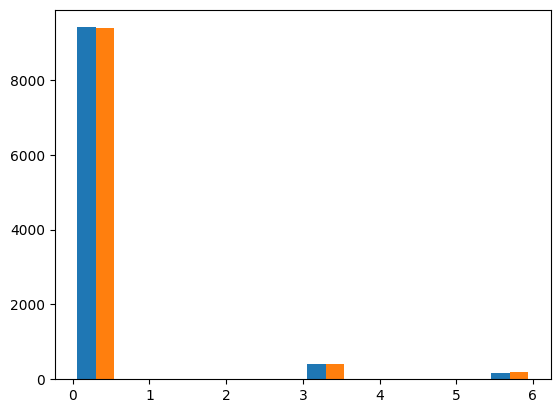

([9406.0 0.0 … 0.0 174.0; 9398.0 0.0 … 0.0 186.0], [0.0, 0.6, 1.2, 1.7999999999999998, 2.4, 3.0, 3.5999999999999996, 4.2, 4.8, 5.3999999999999995, 6.0], NTuple{10, PyCall.PyObject}[(PyObject <matplotlib.patches.Rectangle object at 0x7fea49b2f550>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49b22250>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49b2f8e0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49b2faf0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49b2fd00>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49b2ff10>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49abc160>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49abc370>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49abc580>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49abc790>), (PyObject <matplotlib.patches.Rectangle object at 0x7fea49abc8b0>, PyObject <matplotlib.patches.Rectangle object at 0x7fea49b2f520>, PyObject <matplotlib.pat

In [460]:
hist([ashots, mshots])

In [182]:
M = covariance_matrix(mreg)

6×6 Matrix{Float64}:
  0.0       0.877583   0.395687    0.0         0.0        -0.270704
 -0.877583  0.0        0.0        -0.395687   -0.270704    0.0
 -0.395687  0.0        0.0         0.916612   -0.0570489   0.0
  0.0       0.395687  -0.916612    0.0         0.0        -0.0570489
  0.0       0.270704   0.0570489   0.0         0.0         0.960971
  0.270704  0.0        0.0         0.0570489  -0.960971    0.0

In [183]:
covariance_matrix(areg)

6×6 Matrix{Float64}:
  0.0       0.877583   0.395687    0.0         0.0        -0.270704
 -0.877583  0.0        0.0        -0.395687   -0.270704    0.0
 -0.395687  0.0        0.0         0.916612   -0.0570489   0.0
  0.0       0.395687  -0.916612    0.0         0.0        -0.0570489
  0.0       0.270704   0.0570489   0.0         0.0         0.960971
  0.270704  0.0        0.0         0.0570489  -0.960971    0.0

In [184]:
i = 1
pi = 0.5(1 - M[2i-1,2i])

0.06120871905481362

In [185]:
Πi = 0.5 * (put(nq, i => I2) - put(nq, i => Z))

nqubits: 3
[scale: 0.5] +
   ├─ put on (1)
   │  └─ I2
   └─ [-] put on (1)
         └─ Z


In [186]:
areg |> Πi
@show abs2(norm(areg))
normalize!(areg)

abs2(norm(areg)) = 0.06120871905481365


ArrayReg{2, ComplexF64, Array...}
    active qubits: 3/3
    nlevel: 2

In [187]:
j = 2
Πj = 0.5 * (put(nq, j => I2) - put(nq, j => Z))
areg |> Πj
abs2(norm(areg))

0.6811788772383368

In [188]:
ni = 1
update_covariance_matrix!(M, i, pi, ni)
M[3:end,3:end]

4×4 Matrix{Float64}:
  0.0        -0.362358   -0.932039   0.0
 -0.916612    0.0         0.0       -0.932039
  0.0570489   0.0         0.0        0.362358
  0.0         0.0570489  -0.960971   0.0

In [189]:
pj = 0.5(1 - M[2j-1,2j])

0.6811788772383371

In [190]:
normalize!(areg)
k = 3
Πk = 0.5 * (put(nq, k => I2) - put(nq, k => Z))
areg |> Πk
abs2(norm(areg))

0.0

In [191]:
nj = 1
update_covariance_matrix!(M, j, pj, nj)
M[5:end,5:end]

2×2 Matrix{Float64}:
  0.0       1.0
 -0.960971  0.0

In [192]:
pk = 0.5(1 - M[2k-1,2k])

5.551115123125783e-17

In [166]:
using SymEngine

In [171]:
areg = arrayreg(bit"101")

ArrayReg{2, ComplexF64, Array...}
    active qubits: 3/3
    nlevel: 2

In [173]:
samples = measure(areg, [1,3,2], nshots=15)

15-element Vector{DitStr{2, 3, Int64}}:
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎

In [205]:
sortperm([3,5,6,2])

4-element Vector{Int64}:
 4
 1
 2
 3

In [206]:
invperm(sortperm([3,5,6,2]))

4-element Vector{Int64}:
 2
 3
 4
 1

In [178]:
BitStr{10}(BigInt(185))

0010111001 ₍₂₎

In [177]:
?BitStr

search: BitStr bitstring @bit_str QubitMismatchError SubstitutionString



```
BitStr{N,T} <: Integer
```

The struct for bit string with fixed length `N` and storage type `T`. It is an alias of `DitStr{2,N,T}`.

```
BitStr{N,T}(integer)
BitStr64{N}(integer)
BitStr64(vector)
LongBitStr{N}(integer)
LongBitStr(vector)
```

Returns a `BitStr`. When the input is an integer, the bits are read from right to left. When the input is a vector, the bits are read from left to right.

## Examples

`BitStr` supports some basic arithmetic operations. It acts like an integer, but supports some frequently used methods for binary basis.

```jldoctest
julia> bit"0101" * 2
1010 ₍₂₎

julia> join([bit"101" for i in 1:10])
"101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎101 ₍₂₎"

julia> repeat(bit"101", 2)
101101 ₍₂₎

julia> bit"1101"[2]
0
```


In [113]:
pj = 0.5(1 - M[2j-1,2j])

0.6811788772383371

In [134]:
sortperm(1:5)

1:5

In [152]:
@time sortperm(1:10000)

  0.000001 seconds


1:10000

In [151]:
a = collect(1:10000)
@time sortperm(a)

  0.000126 seconds (3 allocations: 78.188 KiB)


10000-element Vector{Int64}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
     ⋮
  9989
  9990
  9991
  9992
  9993
  9994
  9995
  9996
  9997
  9998
  9999
 10000